In [1]:
rm(list=ls()) 
setwd("/scratch/AG_Ohler/CheWei/Root_scATAC/")

In [2]:
suppressMessages(library(cicero))
suppressMessages(library(monocle3))

In [3]:
## You can substitute the data path below with the data path of your scATAC data
## Downloaded from ARVEX (GSE155304:GSM4698760)
data_folder <- "af_1_output/outs/filtered_peak_bc_matrix"

# Create a folder to save results
output_folder <- "cicero_output"
dir.create(output_folder)

Warning message in dir.create(output_folder):
"'cicero_output' already exists"


In [4]:
# Read in matrix data using the Matrix package
indata <- Matrix::readMM(paste0(data_folder, "/matrix.mtx"))
# Binarize the matrix
indata@x[indata@x > 0] <- 1

# Format cell info
cellinfo <- read.table(paste0(data_folder, "/barcodes.tsv"))
row.names(cellinfo) <- cellinfo$V1
names(cellinfo) <- "cells"

# Format peak info
peakinfo <- read.table(paste0(data_folder, "/peaks.bed"))
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name

row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

# Make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,]

In [5]:
input_cds

class: cell_data_set 
dim: 25377 3270 
metadata(1): cds_version
assays(1): counts
rownames(25377): 1_335_7056 1_8406_9951 ... 5_26957455_26961494
  5_26962568_26975462
rowData names(5): chr bp1 bp2 site_name num_cells_expressed
colnames(3270): AAACGAAAGCGCCTAC-1 AAACGAAAGTACAGTA-1 ...
  TTTGTGTCACAGGAAC-1 TTTGTGTGTAGTCTGT-1
colData names(3): cells Size_Factor num_genes_expressed
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

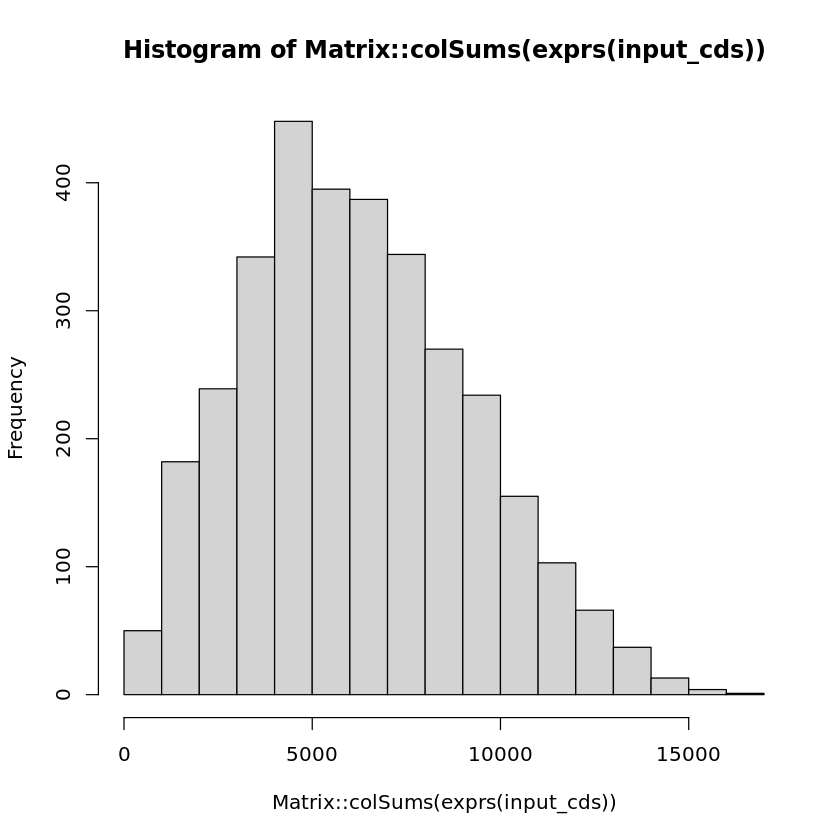

In [6]:
## Quality Check and filtering
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

In [7]:
# Filter cells by peak_count
# Please set an appropriate threshold values according to your data
max_count <-  15000
min_count <- 2000
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) >= min_count]
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) <= max_count]

In [8]:
## Process Cicero object
# Data preprocessing
set.seed(2017)

input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")

# Dimensional reduction with umap
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP',
                              preprocess_method = "LSI")
umap_coords <- reducedDims(input_cds)$UMAP


cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

# Save cds object if you want
saveRDS(cicero_cds, paste0(output_folder, "/cicero_cds.Rds"))

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.937935257788518
Median shared cells bin-bin: 0



In [11]:
cicero_cds

class: cell_data_set 
dim: 25377 1018 
metadata(1): cds_version
assays(1): counts
rownames(25377): 1_335_7056 1_8406_9951 ... 5_26957455_26961494
  5_26962568_26975462
rowData names(5): chr bp1 bp2 site_name num_cells_expressed
colnames(1018): agg293 agg1996 ... agg1523 agg1186
colData names(3): agg_cell Size_Factor num_genes_expressed
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [12]:
# !!Please make sure that the reference genome information below match the reference genome of your scATAC-seq data.

# If your scATAC-seq uses mm10 reference genome, you can read chromosome length file with the following command.
#download.file(url = "https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/mm10_chromosome_length.txt",
#              destfile = "./mm10_chromosome_length.txt")
#chromosome_length <- read.table("./mm10_chromosome_length.txt")
chromosome_length <- data.frame(V1=c("1","2","3","4","5","MT","Pltd"),V2=c(30427671,19698289,23459830,18585056,26975502,366924,154478))

In [13]:
chromosome_length

V1,V2
<chr>,<dbl>
1,30427671
2,19698289
3,23459830
4,18585056
5,26975502
Mt,366924
Pt,154478


In [14]:
# Run the main function
conns <- run_cicero(cicero_cds, chromosome_length) # Takes a few minutes to run

# Save results if you want
#saveRDS(conns, paste0(output_folder, "/cicero_connections.Rds"))

# Check results
head(conns)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  477"
[1] "Other models: "

Zero or one element in range 
                           4 
[1] "Models with errors:  0"
[1] "Done"


,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,1_10009064_10010347,1_9750080_9750307,0.0796603471
2,1_10009064_10010347,1_9751793_9754234,0.0587116311
3,1_10009064_10010347,1_9756523_9756940,0.1968166285
4,1_10009064_10010347,1_9757841_9758508,0.0002570429
5,1_10009064_10010347,1_9761163_9761218,-0.0128699915
6,1_10009064_10010347,1_9762190_9762559,-0.0601503103


In [15]:
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(output_folder, "/all_peaks.csv"))
write.csv(x = conns, file = paste0(output_folder, "/cicero_connections.csv"))